In [3]:
# Name Classification
# 각 나라별 last name을 입력으로 받고, last name의 각 알파벳들을 RNN의 입력 하나로 사용
# util code
import io
import os
import unicodedata
import string
import glob

import torch
import random

# Alphabet small + capital letters +".,;'"
ALL_LETTERS = string.ascii_letters + ".,;'"
N_LETTERS = len(ALL_LETTERS)

# Unicode string -> plain ASCII
# Special Unicode string을 ASCII로 변환함
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)
    
    # Read file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories

# Find letter index from all_letters(ex: 'a' == 0)
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# For demonstration. Turn letter into <1 x n_letters> Tensor
# 알파벳 하나를 one-hot vector로 변환
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn line into <line_length x 1 x n_letters>, or an array of one-hot letter vectors
# 한 라인의 알파벳들(last_name)을 one_hot vector들의 list로 변환
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

def random_training_example(category_lines, all_categories):
    def random_choice(a):
        random_idx = random.randint(0, len(a)-1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [6]:
# RNN
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class RNN(nn.Module):
    ## nn.RNN from scratch
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)    # input to hidden state, combine input and hidden state
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # Softmax along dimension 1

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), dim=1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
    # Helper function. Initial hidden state in the beginning
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size) # 첫 hidden state 정의. 전부 0으로 이루어진 hidden state와 같은 크기의 zero tensor

# category_lines: dict. {country: [name]}
# all_categories: list. All different countries
category_lines, all_categories = load_data()
n_categories = len(all_categories)  # 18 different countries
print(n_categories)

18


In [8]:
n_hidden = 128   # Hyperparameter
rnn = RNN(N_LETTERS, n_hidden, n_categories)  # input_size: 가능한 알파벳 수, output_size: number of classes (각기 다른 국가 수)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())    # output_size
print(next_hidden.size())   # hidden state size

torch.Size([1, 18])
torch.Size([1, 128])


In [11]:
# Whole sequence(name)
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())    # output_size
print(next_hidden.size())   # hidden state size

torch.Size([1, 18])
torch.Size([1, 128])


In [13]:
# Helper function
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]
print(category_from_output(output)) # Not trained yet

Greek


4999 4.999 1.7536 Molotov / Russian CORRECT
9999 9.998999999999999 2.7887 Houte / Arabic WRONG (Dutch)
14999 14.999 2.4910 Bach / Vietnamese WRONG (German)
19999 19.999 1.4666 Vinh / Vietnamese CORRECT
24999 24.999 0.8976 Ly / Vietnamese CORRECT
29999 29.999 2.0682 Blober / German WRONG (Czech)
34999 34.999 0.4911 Tatsuko / Japanese CORRECT
39999 39.999 0.4726 Kuijpers / Dutch CORRECT
44999 44.999 0.7342 Yep / Chinese CORRECT
49999 49.999 2.8590 Delgado / Italian WRONG (Portuguese)
54999 54.998999999999995 0.6978 Nijo / Japanese CORRECT
59999 59.999 0.4972 Valiev / Russian CORRECT
64999 64.999 0.3019 Czajka / Polish CORRECT
69999 69.999 2.9734 Gaspar / Arabic WRONG (Spanish)
74999 74.99900000000001 0.5016 Hwang / Korean CORRECT
79999 79.999 3.1745 Russell / Irish WRONG (Scottish)
84999 84.999 0.8056 Barros / Portuguese CORRECT
89999 89.999 1.8322 Airo / Portuguese WRONG (Italian)
94999 94.999 0.1080 Demakis / Greek CORRECT
99999 99.99900000000001 0.2289 Millar / Scottish CORRECT


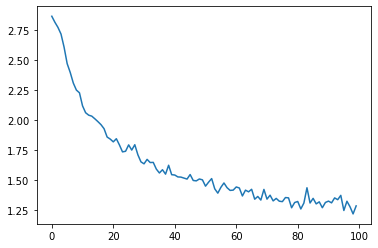


> Kim
Korean

> kim
Russian

> Lee
Chinese

> Lei
Chinese

> Gwang
Korean

> Heo
Chinese

> Ye
Korean

> a
Spanish

> Kbak
Polish


In [16]:
criterion = nn.NLLLoss()    # Negative Log Likelihood Loss
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor): # get line(whole name) tensor, category tensor (각 line별 class)
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)    # 각 line의 알파벳 하나씩 입력으로 받음. hidden은 rnn 통과할 때마다 갱신

    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()  # output과 계산한 loss의 float value만 return

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i} {i/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        guess = category_from_output(output)
        print(guess)

# Save model
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)